# Client Churn Using Tree-Based Classification Models

#### Table of Content

1. Project Summary
2. Data Source
3. Load Libraries & Data
4. Feature Engineering
5. Descriptive Statistics
6. Train, Test, Split
7. Decision Tree Classifier
8. Random Forest Classifier
9. AdaBoost & XGBoost Classifiers
10. Business Value Add

#### Project Summary

Start Summary here.

#### Data Source

The following client churn data feeds various classification dt_models that utilize tree-methods (decision trees, random forests, and gradient boosted trees).  Toward the end of the notebook, there is a comparison in performance metrics across these dt_models.

https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers


* churn.csv: Client churn data for bank customers. Contains variables:

    * CustomerId: contains random values and has no effect on customer leaving the bank
    * Surname: the surname of a customer has no impact on their decision to leave the bank.
    * CreditScore: can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
    * Geography: a customer’s location can affect their decision to leave the bank.
    * Gender: it’s interesting to explore whether gender plays a role in a customer leaving the bank.
    * Age: this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
    * Tenure: refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
    * Balance: also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
    * NumOfProducts: refers to the number of products that a customer has purchased through the bank.
    * IsActiveMember: active customers are less likely to leave the bank.
    * EstimatedSalary: as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
    * Exited: whether or not the customer left the bank.

**The goal is to  create a dt_model that predicts whether a client will churn based their attributes.**

#### Load Libraries & Data

In [181]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

After importing the required libraries, the churn.csv file is read into a pandas dataframe with the first 5 rows displayed.

In [182]:
df = pd.read_csv('/Users/colefairbanks/GitHub/trees-clientchurn-banks/churn.csv')
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Feature Engineering

The importance of feature engineering cannot be underscored enough when building machine learning dt_models.  The old mantra, "garbage-in garbage-out," can many times be remedied by handling missing data, non-linearity, complex dimensionality, etc. during the feature engineering process.  By scrubbing clean the data flowing into your dt_model, you can expect vastly improved performance.

That said, it is always a good idea to use the .info() function to get a feel for dataset quality.

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


As you can see, this dataset practically came gift-wrapped - no null values, correct data types, and a nice 10,000 row sample.  However, there is missing information that was probably removed on-purpose for privacy reasons that we can recreate for real-world application; namely, email address and phone number.

* Email addresses are created based on "Surname" and simply adding "@gmail.com."
* Phone numbers are random, unique 9-digit numbers.

In [184]:
df['Email'] = df['Surname'].str.lower() + '@gmail.com'

In [185]:
df['Phone'] = [random.randint(100000000, 999999999) for i in range(10000)]
df['Phone'] = df['Phone'].astype(str)
df['Phone'] = df['Phone'].str[:3] + '-' + df['Phone'].str[3:6] + '-' + df['Phone'].str[6:]

Data Scientists who work with classification dt_models and customer data tend to pay attention to whether each column contains numeric or string values in addition to how they are grouped.  CustomerId, Surname, Email, and Phone, while typical fields, present a problem - they are unique and likely irrelevant.  Therefore, we should remove these columns; however, before doing so, we need a way to add back this information later, as our ultimate goal is to target these customers to prevent them from churning.  And so, we will create mapping dictionaries that are tied to unique customer IDs.

In [186]:
email_dict = df[['CustomerId', 'Email']].set_index('CustomerId')['Email'].to_dict()
phone_dict = df[['CustomerId', 'Phone']].set_index('CustomerId')['Phone'].to_dict()
surname_dict = df[['CustomerId', 'Surname']].set_index('CustomerId')['Surname'].to_dict()

With the information saved, we can now drop the irrelevant columns.

In [187]:
df.drop(['Surname', 'Email', 'Phone'], axis=1, inplace=True)

However, we are not going to drop "CustomerId", as this what our dictionaries eventually will map to.  Instead, we are going to set the index to this field instead of using standard row numbers.  Doing so ensures we can retain this information throughout the dt_model without adding additional noise.

In [188]:
df = df.set_index('CustomerId')

Another problem we face as of July 12, 2023 is sklearn's inability to interpret non-numerical text as categorical.  This affects "Gender" and "Geography" within our current dataframe, which contain: Female, Male, France, Germany, and Spain.

In [189]:
df.groupby(['Gender'], as_index=False).count()[['Gender']]

,Gender
0,Female
1,Male


In [190]:
df.groupby(['Geography'], as_index=False).count()[['Geography']]

,Geography
0,France
1,Germany
2,Spain


Our first instinct might be to assign a value like 0 to Female and 1 to Male - or 0 to France, 1 to Germany, and 2 to Spain.  However, this is risky, because sklearn might interpret these as ordinal values, which inserts bias via an unintentionally ranking.

Instead, we can implement a technique called "one-hot encoding" using the .get_dummies() pandas function.  This involves automatically creating new columns with binary classifications of True and False.  You will notice astype(int) is added - this converts True and False to integers 0 and 1.

* Bonus: drop_first=True is included to eliminate "Geography_France."  Why? To prevent multicollinearity - correlations between features.  Having drop_first is good statistical hygiene in my opinion, especially if dt_models like these are designed to be scaled eventually.

In [191]:
df = pd.get_dummies(df, drop_first=True).astype(int)

Let's order our columns and take a look at our cleaned, numeric dataframe.

In [192]:
df = df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'
         , 'Geography_Germany', 'Geography_Spain', 'Gender_Male', 'Exited']]
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Exited
CustomerId,,,,,,,,,,,,
15634602,619,42,2,0,1,1,1,101348,0,0,0,1
15647311,608,41,1,83807,1,0,1,112542,0,1,0,0
15619304,502,42,8,159660,3,1,0,113931,0,0,0,1
15701354,699,39,1,0,2,0,0,93826,0,0,0,0
15737888,850,43,2,125510,1,1,1,79084,0,1,0,0


Looks good.  Next, descriptive statistics.

#### Descriptive Statistics

In [193]:
#sns.boxplot(x='CreditScore',y='Exited',data=df)

In [194]:
#sns.scatterplot(x='CreditScore',y='Age',data=df,hue='Exited',palette='Dark2')

In [195]:
#sns.pairplot(df,hue='Exited',palette='coolwarm')

In [196]:
#sns.catplot(x='species',y='culmen_length_mm',data=df,kind='box',col='sex',palette='Dark2')

## Train | Test Split

As a first step, the feature columns need to be separated from the target, "Exited."

In [197]:
X = df.iloc[:, :-1]
y = df['Exited']

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#### Decision Tree Classifier

In [199]:
dt_model = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=4)

In [200]:
dt_model.fit(X_train,y_train);

In [201]:
dt_predictions = dt_model.predict(X_test)

Evaulation.

In [203]:
cm = confusion_matrix(y_test, dt_predictions)
print(classification_report(y_test, dt_predictions))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2378
           1       0.63      0.46      0.53       622

    accuracy                           0.83      3000
   macro avg       0.75      0.70      0.72      3000
weighted avg       0.82      0.83      0.82      3000



[Text(0, 0.5, 'No Exit'), Text(0, 1.5, 'Exited')]

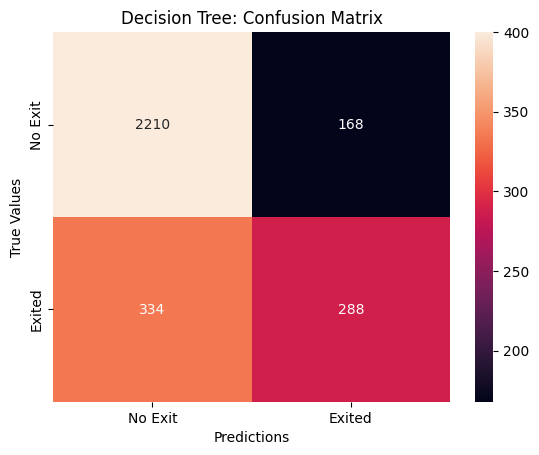

In [206]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, vmax=400);

# labels, title and ticks
ax.set_xlabel('Predictions');ax.set_ylabel('True Values'); 
ax.set_title('Decision Tree: Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Exit', 'Exited']); ax.yaxis.set_ticklabels(['No Exit', 'Exited'])

In [207]:
dt_model.feature_importances_
pd.DataFrame(index=X.columns,data=dt_model.feature_importances_,columns=['FeatureImportance']).sort_values(by='FeatureImportance', ascending=False)

,FeatureImportance
Age,0.570944
IsActiveMember,0.230251
NumOfProducts,0.198806
CreditScore,0.000000
Tenure,0.000000
Balance,0.000000
HasCrCard,0.000000
EstimatedSalary,0.000000
Geography_Germany,0.000000
Geography_Spain,0.000000


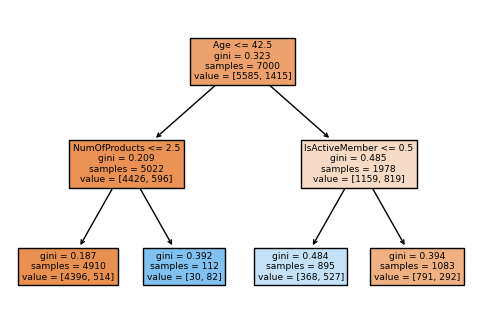

In [208]:
plt.figure(figsize=(6,4))
tree.plot_tree(dt_model,filled=True,feature_names=list(X.columns));

---